# Policy search
Policy search RL algorithm for playing the game of Space Invaders.

In [374]:
import random

import ale_py
import gymnasium as gym

gym.register_envs(ale_py)  # needed to run atari games

In [375]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## preprocess
We need to crop the frame, downsample it, and convert it to grayscale.

In [376]:
def preprocess_frame(frame):
    frame = frame[34:194]
    frame = frame[::2, ::2, 0]
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    frame[frame != 0] = 1
    return np.expand_dims(frame.astype(np.float32), axis=0)

def preprocess_batch(states):
    return np.array([preprocess_frame(state) for state in states])

In [377]:
class PolicyNetwork(nn.Module):
    def __init__(self, action_space):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return nn.Softmax(dim=-1)(x)

In [378]:
def compute_discounted_rewards(rewards, gamma, baseline=None):
    discounted_rewards = np.zeros_like(rewards)
    cumulative = 0
    for t in reversed(range(len(rewards))):
        cumulative = rewards[t] + gamma * cumulative
        discounted_rewards[t] = cumulative

    if baseline is not None:
        discounted_rewards -= baseline
    return discounted_rewards

In [379]:
def create_env(seed):
    def _init():
        env = gym.make('ALE/SpaceInvaders-v5', frameskip=3)
        env.reset(seed=seed)
        return env
    return _init

In [380]:
def play_one_step(env, state, model):
    # get stochastic action
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action_probs = model(state)
    dist = Categorical(action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    # take action
    next_state, reward, done, truncated, info = env.step(action.item())
    next_state = preprocess_frame(next_state)
    return next_state, reward, done, truncated, log_prob


def play_multiple_episodes(n_episodes, n_max_steps, model, seed, gamma):
    envs = gym.vector.AsyncVectorEnv([create_env(seed + i) for i in range(n_episodes)])
    all_rewards = [[] for _ in range(n_episodes)]
    all_log_probs = [[] for _ in range(n_episodes)]
    all_baselines = [[] for _ in range(n_episodes)]

    states, _ = envs.reset()
    states = preprocess_batch(states)

    for step in range(n_max_steps):
        state_tensors = torch.tensor(states, dtype=torch.float32, device=device)
        action_probs = model(state_tensors)
        dist = Categorical(action_probs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)

        next_states, rewards, dones, truncations, infos = envs.step(actions.cpu().numpy())

        for i in range(n_episodes):
            all_rewards[i].append(rewards[i])
            all_log_probs[i].append(log_probs[i])

        states = preprocess_batch(next_states)
        if any(dones) or any(truncations):
            break

    for i in range(n_episodes):
        discounted = compute_discounted_rewards(all_rewards[i], gamma)
        all_baselines[i] = np.mean(discounted)

    envs.close()

    return all_rewards, all_log_probs, all_baselines

In [381]:
class Parameters:
    def __init__(self):
        self.n_iterations = 1000  # max episodes
        self.n_episodes_per_update = 10  # batch size
        self.n_max_steps = 1_000_000_000  # how many steps to perform during a game

        self.discount_factor = 0.99  # gamma
        self.learning_rate = 1e-2  # alfa

        self.early_stopping_patience = 20
        self.early_stopping_delta = 1e-3

In [382]:
env = gym.make('ALE/SpaceInvaders-v5', frameskip=3)
# env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=50) ??? nie dziala dziadostwo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [383]:
n_iterations = 1000
n_max_steps = 1_000_000
early_stopping_delta = 1e-3
early_stopping_patience = 20
early_stopping_lookback = 30

In [ ]:
import itertools
import matplotlib.pyplot as plt

# Hyperparameter grid for cross-validation
learning_rates = [1e-3, 1e-2]
gammas = [0.95, 0.99]
batch_sizes = [6, 12, 24]
seeds = [1,2,3,5,8]

# Grid search over hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, gammas, batch_sizes))

results = {}

# Cross-validation loop
for learning_rate, gamma, batch_size in hyperparameter_combinations:
    seed_rewards = []

    for seed in seeds:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        episode_rewards = []
        best_mean_reward = -np.inf
        patience_counter = 0

        policy = PolicyNetwork(env.action_space.n).to(device)
        optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

        for iteration in range(n_iterations):
            all_rewards, all_log_probs, all_baselines = play_multiple_episodes(
                batch_size, n_max_steps, policy, seed, gamma
            )

            all_final_rewards = [
                compute_discounted_rewards(rewards, gamma, baseline=b)
                for rewards, b in zip(all_rewards, all_baselines)
            ]

            policy_loss = 0
            for log_probs, rewards in zip(all_log_probs, all_final_rewards):
                log_probs_tensor = torch.stack(log_probs)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                policy_loss += -torch.sum(log_probs_tensor * rewards_tensor)

            policy_loss /= batch_size

            episode_rewards.append(np.mean([np.sum(rewards) for rewards in all_rewards]))
            if iteration % 10 == 0:
                print(f"LR: {learning_rate}, Gamma: {gamma}, Batch: {batch_size}, "
                      f"Seed: {seed}, Iteration: {iteration}, Reward: {episode_rewards[-1]}")

            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()

            # Early stopping
            if iteration < early_stopping_lookback:
                continue
            current_mean_reward = np.mean(episode_rewards[-early_stopping_lookback:])
            if abs(current_mean_reward - best_mean_reward) > early_stopping_delta:
                best_mean_reward = current_mean_reward
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter == early_stopping_patience:
                print(f"LR: {learning_rate}, Gamma: {gamma}, Batch: {batch_size}, "
                      f"Seed: {seed}, Early stopping at iteration {iteration}")
                break

        seed_rewards.append(episode_rewards)

    # Store the results for this hyperparameter combination
    results[(learning_rate, gamma, batch_size)] = seed_rewards

LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 0, Reward: 87.5
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 10, Reward: 164.16666666666666
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 20, Reward: 59.166666666666664
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 30, Reward: 180.83333333333334
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 40, Reward: 60.833333333333336
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 50, Reward: 65.0
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 60, Reward: 68.33333333333333
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 70, Reward: 81.66666666666667
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 80, Reward: 63.333333333333336
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 90, Reward: 71.66666666666667
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 100, Reward: 76.66666666666667
LR: 0.001, Gamma: 0.95, Batch: 6, Seed: 1, Iteration: 110, Reward: 141.66666666666666
LR: 0.001, 

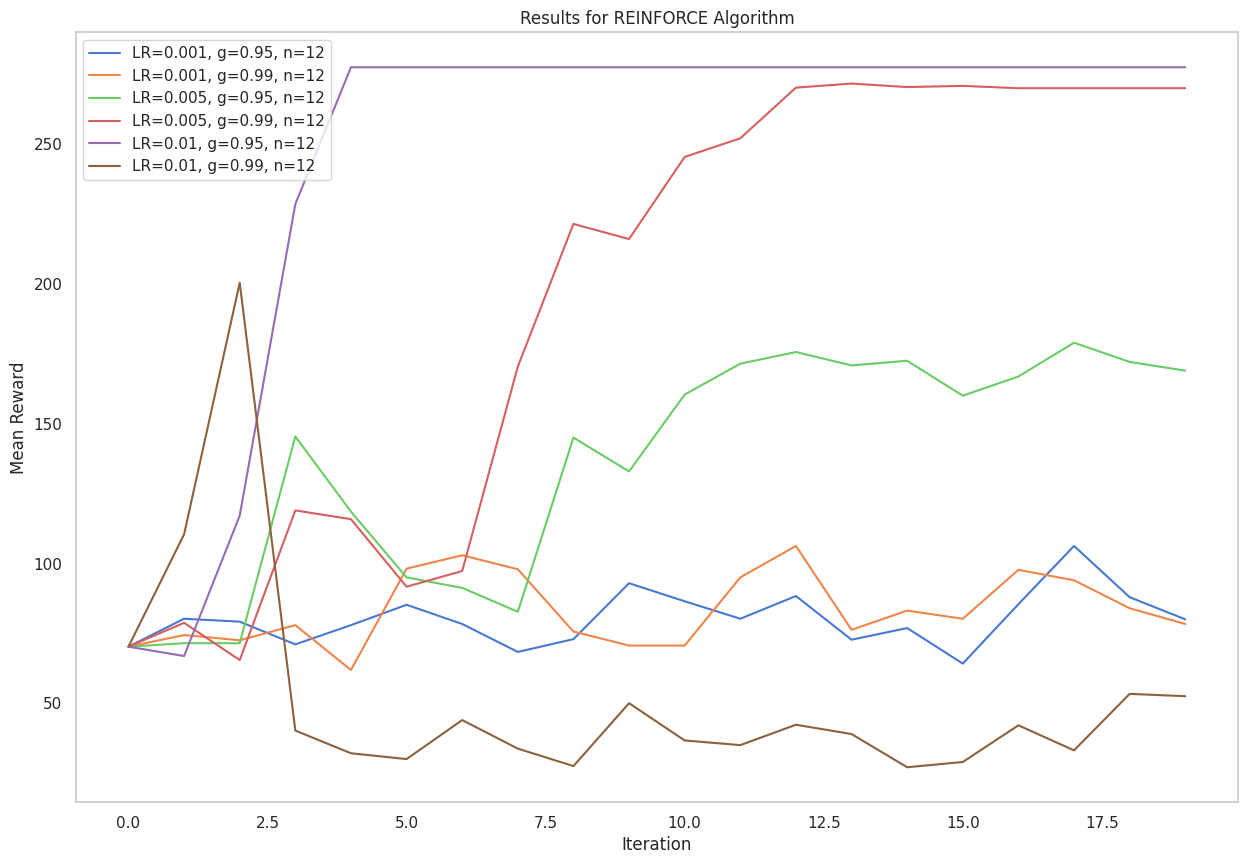

In [373]:
plt.figure(figsize=(15, 10))

for (learning_rate, gamma, batch_size), seed_rewards in results.items():
    mean_reward_per_iteration = np.mean(seed_rewards, axis=0)
    label = f"LR={learning_rate}, g={gamma}, n={batch_size}"
    plt.plot(mean_reward_per_iteration, label=label)

plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.title('Results for REINFORCE Algorithm')
plt.legend()
plt.grid()
plt.show()

In [367]:
# rewards_for_plot = [[reward for reward in rewards] for rewards in seed_rewards]
# rewards_for_plot = pd.DataFrame(rewards_for_plot).melt()
# rewards_for_plot.rename(columns={"variable": "episode", "value": "reward"}, inplace=True)
# sns.set(style="whitegrid", palette="muted")
# sns.lineplot(x="episode", y="reward", data=rewards_for_plot)
# plt.show()